In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset


In [2]:
df = pd.read_csv('labels.csv')
df.head()

,sub1,sub2,problem,verdict
0,0fd5b95a,6490bbe8,19,0
1,464a03b8,ff1fc018,20,0
2,3e6def38,548ffb07,14,1
3,0b91922c,71a4f6d2,6,0
4,9291ca83,d6fb3b9e,15,0


In [3]:
loaded_data = np.load("embeddings/hyb_emb.npz")
embeddings = {key: loaded_data[key] for key in loaded_data}

In [4]:
train_labels=pd.read_csv('train_pairs.csv')

ast_pairs_train = []
labels_train = []

for _, row in train_labels.iterrows():  
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_train.append((ast1, ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_train.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])

test_labels = pd.read_csv('test_pairs.csv')

print(" ")

ast_pairs_test = []
labels_test = []

for _,row in test_labels.iterrows():
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_test.append((ast1,ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_test.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])
   

In [5]:
class CodePlagiarismDataset(Dataset):
    def __init__(self,embed,lab):
        self.embeddings1 = np.array([e[0] for e in embed])
        self.embeddings2 = np.array([e[1] for e in embed])
        self.labels = np.array(lab).astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb1 = torch.tensor(self.embeddings1[idx], dtype=torch.float32)
        emb2 = torch.tensor(self.embeddings2[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return emb1, emb2, label  

In [6]:
import torch
import torch.nn as nn

class SiamesePlagiarismClassifier(nn.Module):
    def __init__(self, input_size=1024): 
        super(SiamesePlagiarismClassifier, self).__init__()

        self.shared_fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512), 
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),  
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        
        )

        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        emb1 = self.shared_fc(emb1)
        emb2 = self.shared_fc(emb2)
        similarity = torch.abs(emb1 - emb2)
        return self.sigmoid(self.out(similarity))


In [7]:
test_dataset = CodePlagiarismDataset(ast_pairs_train,labels_train)
train_dataset = CodePlagiarismDataset(ast_pairs_test,labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
def get_concatenated_features(dataset):
    X_list = []
    for emb1, emb2, _ in dataset:
        concatenated = np.concatenate([emb1.numpy(), emb2.numpy()])
        X_list.append(concatenated)
    return np.array(X_list)

X_train = get_concatenated_features(train_dataset)
X_test  = get_concatenated_features(test_dataset)

print("X_train shape:", X_train.shape)  #(677, 2048)
print("X_test shape:", X_test.shape)    #(228, 2048)


X_train shape: (675, 2048)
X_test shape: (228, 2048)


In [10]:
import numpy as np
import torch

model = SiamesePlagiarismClassifier().to(device)
model.load_state_dict(torch.load('models/50_hyb.pth', map_location=device))


def predict_proba_wrapper(X):
   
    if len(X.shape) == 1:
        X = np.expand_dims(X, axis=0)
    
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    batch_size = X_tensor.shape[0]
    
    emb1 = X_tensor[:, :1024].view(batch_size, -1)
    emb2 = X_tensor[:, 1024:].view(batch_size, -1)
    
    with torch.no_grad():
        outputs = model(emb1, emb2).squeeze()
    
    outputs = torch.sigmoid(outputs).cpu().numpy()
    probs = np.column_stack([1 - outputs, outputs])
    return probs

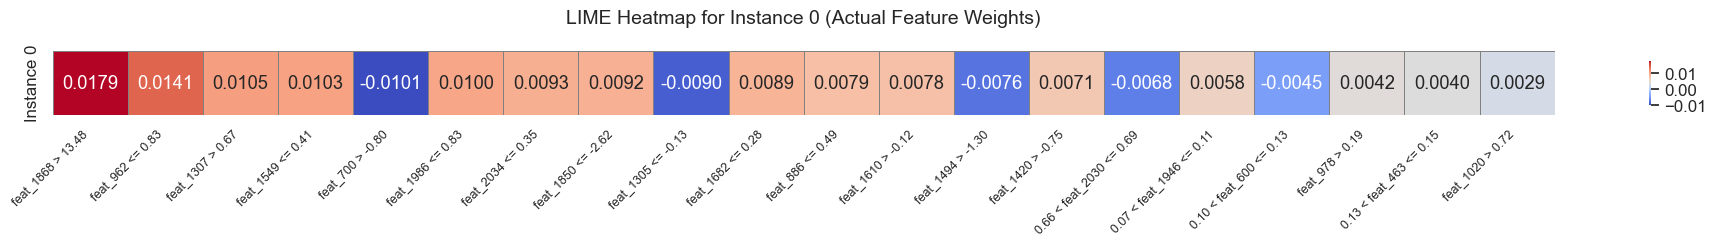

In [11]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f"feat_{i}" for i in range(X_train.shape[1])],
    class_names=["Not Plagiarized", "Plagiarized"],
    mode="classification",
    discretize_continuous=True
)

instance_idx = 0
instance = X_test[instance_idx]

exp = explainer.explain_instance(instance, predict_proba_wrapper, num_features=20)
explanation_list = exp.as_list()

features = [feat for feat, weight in explanation_list]
weights = [weight for feat, weight in explanation_list]

data = np.array([weights])
annotations = np.array([[f"{w:.4f}" for w in weights]])

plt.figure(figsize=(20, 3))  
sns.set(font_scale=1.1)      

ax = sns.heatmap(
    data,
    annot=annotations,
    fmt="",
    cmap="coolwarm",
    xticklabels=features,
    yticklabels=[f"Instance {instance_idx}"],
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.7, "orientation": "vertical"}
)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.title(f"LIME Heatmap for Instance {instance_idx} (Actual Feature Weights)", fontsize=14, pad=20)
plt.tight_layout(pad=2.0)  

# Save and show
plt.savefig("lime_heatmap_spaced.png", dpi=300)
plt.show()


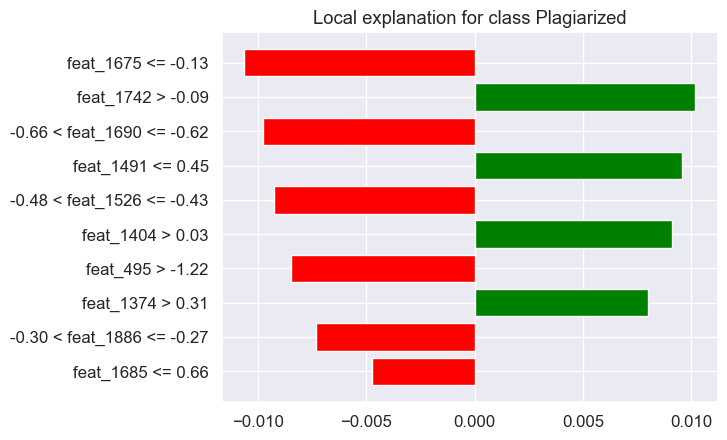

In [12]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f'feat_{i}' for i in range(X_train.shape[1])],
    class_names=["Not Plagiarized", "Plagiarized"],
    mode='classification',
    discretize_continuous=True
)

def explain_instance_lime(instance_index):
    """
    Generates and displays a LIME explanation for a specified test instance.
    """
    instance = X_test[instance_index]
    # Use the predict_proba_wrapper instead of model.predict_proba
    exp = explainer_lime.explain_instance(instance, predict_proba_wrapper, num_features=10)
    
    # Display the explanation as a matplotlib figure
    fig = exp.as_pyplot_figure()
    plt.show()
    fig.savefig("lime_plot.png", bbox_inches='tight')
    plt.close(fig)

# Example: Explain the first test sample using LIME
explain_instance_lime(0)

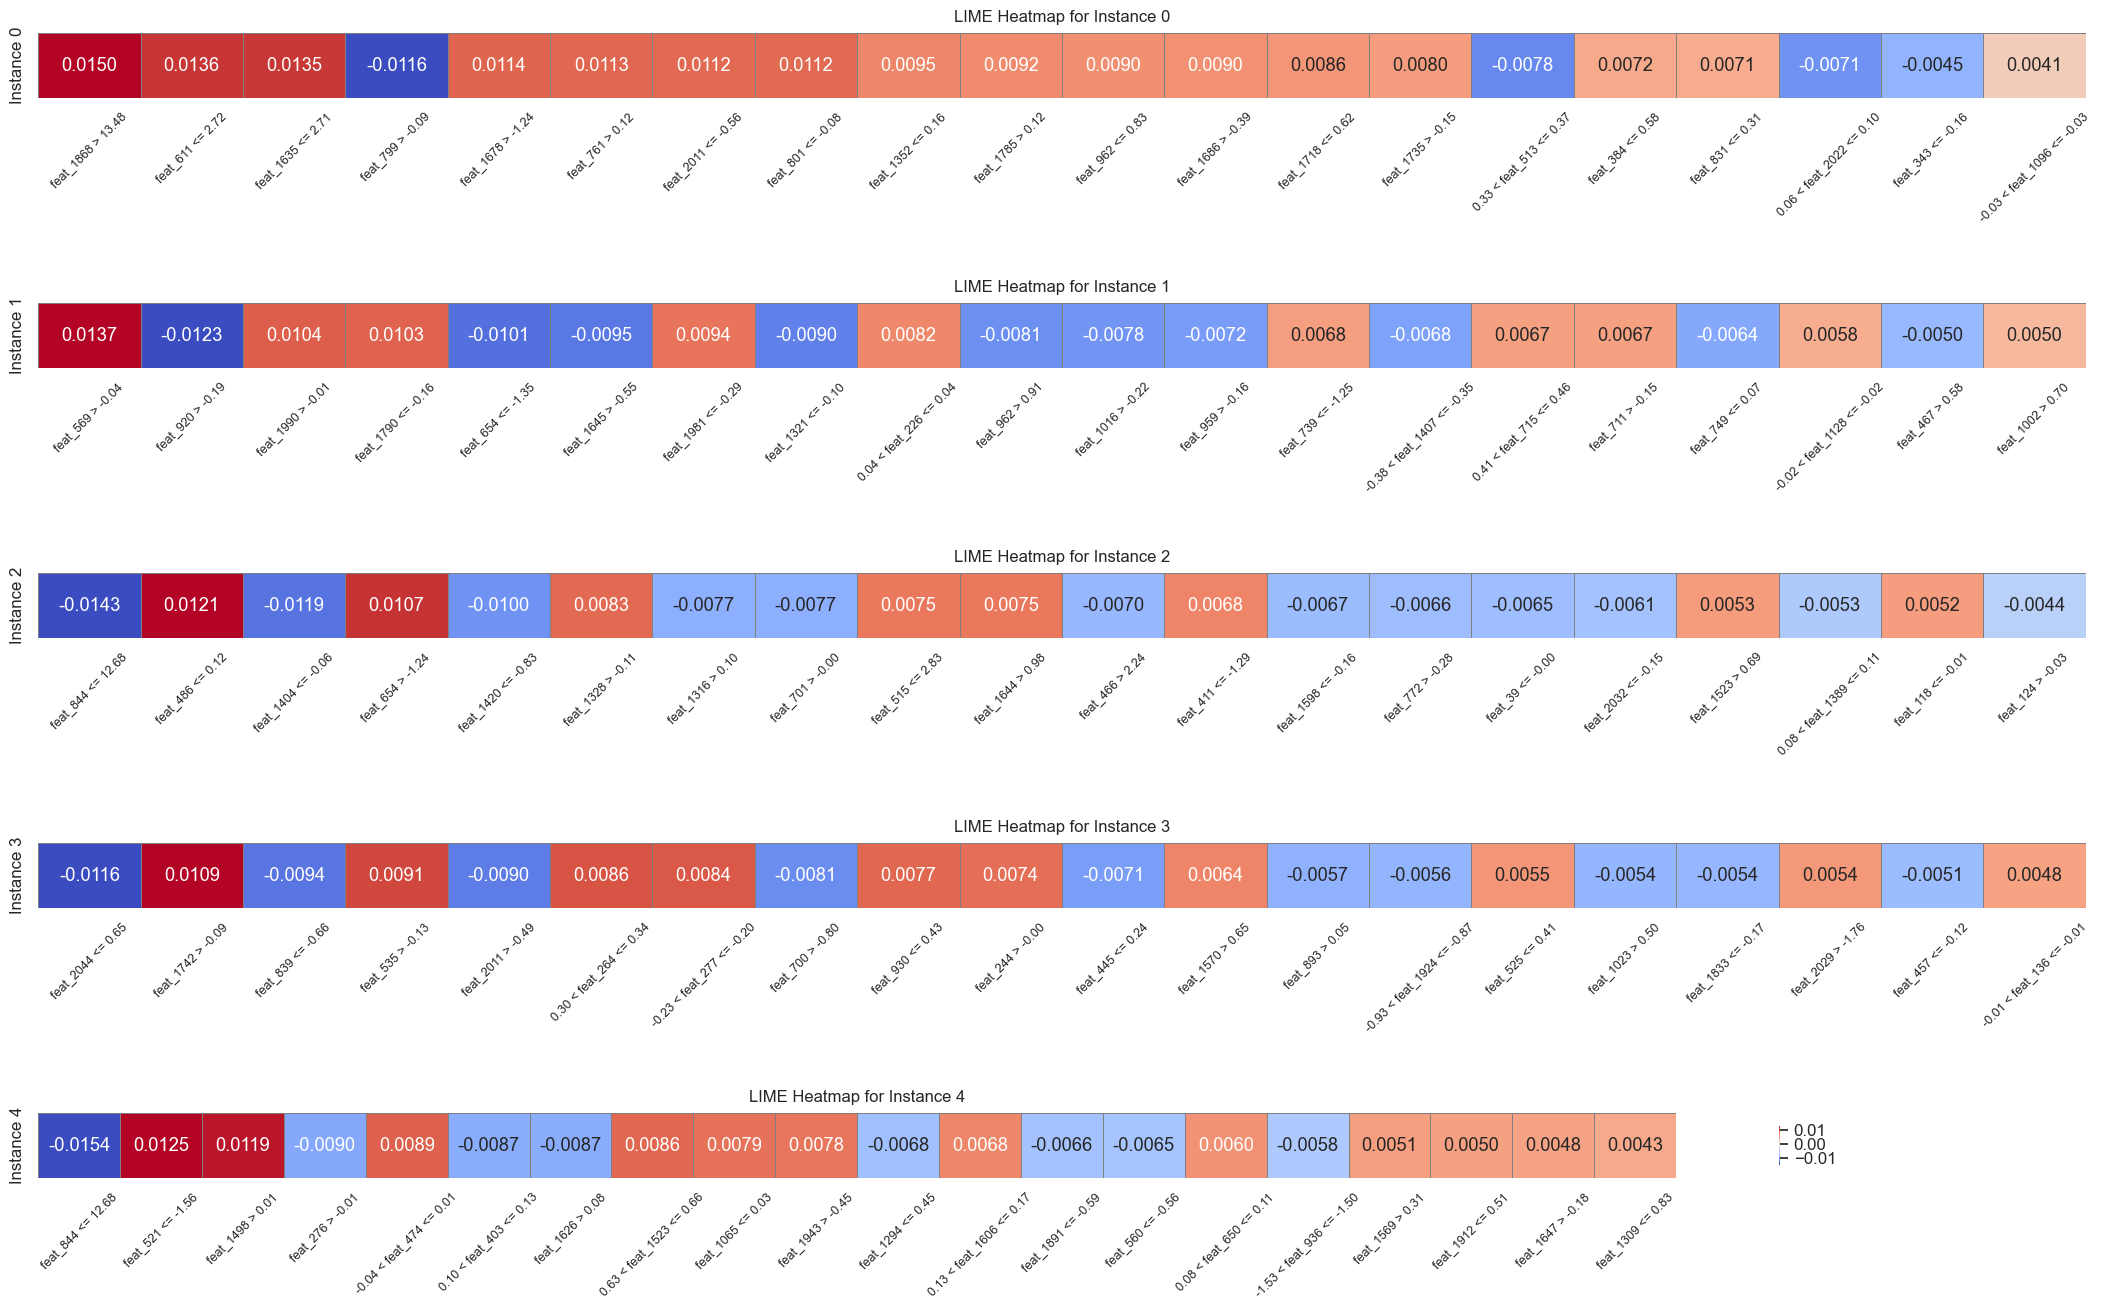

In [13]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f"feat_{i}" for i in range(X_train.shape[1])],
    class_names=["Not Plagiarized", "Plagiarized"],
    mode="classification",
    discretize_continuous=True
)


num_instances = 5
num_features = 20


fig, axes = plt.subplots(num_instances, 1, figsize=(22, num_instances * 2.8))
sns.set(font_scale=1.1)

for idx in range(num_instances):
    instance = X_test[idx]
    exp = explainer.explain_instance(instance, predict_proba_wrapper, num_features=num_features)
    explanation_list = exp.as_list()
    
    features = [feat for feat, weight in explanation_list]
    weights = [weight for feat, weight in explanation_list]
    
    data = np.array([weights])
    annotations = np.array([[f"{w:.4f}" for w in weights]])
    
    ax = axes[idx] if num_instances > 1 else axes
    sns.heatmap(
        data,
        annot=annotations,
        fmt="",
        cmap="coolwarm",
        xticklabels=features,
        yticklabels=[f"Instance {idx}"],
        linewidths=0.5,
        linecolor='gray',
        ax=ax,
        cbar=idx == num_instances - 1,  # Show color bar only on last plot
        cbar_kws={"shrink": 0.6} if idx == num_instances - 1 else None
    )
    
    ax.set_title(f"LIME Heatmap for Instance {idx}", fontsize=12, pad=8)
    ax.tick_params(axis='x', labelrotation=45, labelsize=9)
    ax.set_ylabel("")

plt.tight_layout(pad=3.0)
plt.savefig("lime_heatmap_multiple_instances.png", dpi=300)
plt.show()
